In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display

import time
import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [3]:
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


#### Предварительная проверка файлов на соответствие размеру окна

In [4]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label_check(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label, file_path

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
output_ds = files_ds.map(get_waveform_and_label_check, num_parallel_calls=AUTOTUNE)

In [7]:
data = []
lengths = []
for a,b,c in output_ds:
    data.append((a.shape[0],b,c))
    lengths.append(a.shape[0])

In [8]:
idx_yes = [] #список индексов файлов с подходящими размерами
idx_no = [] #список индексов файлов с неподходящими размерами 
for a in range(len(lengths)):
    if lengths[a]<8192:
        idx_no.append(a)
    else:
        idx_yes.append(a)
            
print(len(idx_yes))
print(len(idx_no))
print(len(idx_yes)+len(idx_no))

27310
3518
30828


In [9]:
filenames_filtered = []
for i in range(len(filenames)):
    if i in idx_yes:
        filenames_filtered.append(filenames[i])
len(filenames_filtered)

27310

____________

In [10]:
filenames = tf.random.shuffle(filenames_filtered)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 27310
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F\\kr033a_150.wav', shape=(), dtype=string)


In [11]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 27000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:27000]

train_files = filenames[:18900]
val_files = filenames[18900: 18900 + 5400]
test_files = filenames[-2700:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18900
Validation set size 5400
Test set size 2700


In [12]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11507, 1])

In [13]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [14]:
def get_spectrogram(waveform):
    
    NFFT = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.mdct(waveform, frame_length=NFFT, pad_end=False)

    return spectrogram

In [15]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[1]
    width = spectrogram.shape[0]
    #X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    X = np.array(range(width))
    Y = np.array(range(height))
    ax.pcolormesh(X, Y, spectrogram.T)

In [16]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [17]:
def preprocess_dataset(files,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [18]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
num_frame = [1,3,5,10,15,20]

print('Количество вариантов num_frame', len(num_frame))

Количество вариантов num_frame 6


In [20]:
import time
EPOCHS = 300
batch_size = 64

In [ ]:
k = 0
mymodel = create_model(input_shapes[k])

start_time = time.time()
myhistory = mymodel.fit(train_[k], validation_data=val_[k], 
                        epochs=EPOCHS, verbose=1, 
                        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
y_true = test_labels_[k]
test_acc = sum(y_pred == y_true) / len(y_true) * 100

fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [24]:
from datetime import datetime
import pickle

tests_acc = []
for k in range(len(num_frame)):
    print('---------------------------------------------------------------------')
    print('Количество спектрограмм: ',num_frame[k])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    start_time = time.time()
    print('Подготовка данных...')
    spectr = None
    train_ = None
    val_ = None
    test_ = None
    input_shape = None
    spectr = preprocess_dataset(train_files,num_frame[k])
    train_=spectr
    val_ = preprocess_dataset(val_files,num_frame[k])
    test_ = preprocess_dataset(test_files,num_frame[k])
    for spectrogram, _ in spectr.take(1):
        input_shape = spectrogram.shape
    print('Размер входных данных: ', input_shape)
    train_ = train_.batch(batch_size)
    train_ = train_.cache().prefetch(AUTOTUNE)
    val_ = val_.batch(batch_size)
    val_ = val_.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []
    for audio, label in test_:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())
    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    mymodel = create_model(input_shape)
    print('Обучение...') 
    start_time = time.time()
    myhistory = mymodel.fit(train_, validation_data=val_, epochs=EPOCHS, verbose=0,
                            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Количество спектрограмм: ',num_frame[k], ', accuracy тестовой выборки: ', test_acc, '%')
    
    mymodel.save(f"model_mdct_{k}.h5")
    
    with open(f'./history_mdct_{k}_epoch.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.epoch, filehandle)

    with open(f'./history_mdct_{k}_history.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.history, filehandle)

---------------------------------------------------------------------
Количество спектрограмм:  1
2022-06-09 17:09:39
Подготовка данных...
Размер входных данных:  (1, 4096)
--- 0.0 минут 1.686678409576416 секунд ---
Обучение...
--- 0.0 минут 44.739640951156616 секунд ---
85/85 [==============================] - 0s 3ms/step
Количество спектрограмм:  1 , accuracy тестовой выборки:  84.85185185185186 %
---------------------------------------------------------------------
Количество спектрограмм:  3
2022-06-09 17:10:26
Подготовка данных...
Размер входных данных:  (3, 4096)
--- 0.0 минут 2.448554754257202 секунд ---
Обучение...
--- 1.0 минут 20.367682695388794 секунд ---
85/85 [==============================] - 0s 5ms/step
Количество спектрограмм:  3 , accuracy тестовой выборки:  88.55555555555556 %
---------------------------------------------------------------------
Количество спектрограмм:  5
2022-06-09 17:11:49
Подготовка данных...
Размер входных данных:  (5, 4096)
--- 0.0 минут 2.49856

In [27]:
spectr = None
train_ = None
val_ = None
test_ = None
input_shape = None
test_audio = None
test_labels = None
myhistory = None
mymodel = None

Text(0.5, 1.0, 'Зависимость точности от количества спектрограмм')

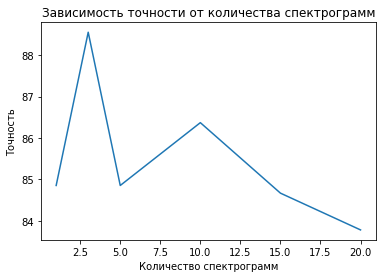

In [28]:
plt.plot(num_frame,tests_acc)
plt.xlabel('Количество спектрограмм')
plt.ylabel('Точность')
plt.title('Зависимость точности от количества спектрограмм')

In [29]:
res = np.array([(num_frame[k], tests_acc[k]) for k in range(len(num_frame))])
res

array([[ 1.        , 84.85185185],
       [ 3.        , 88.55555556],
       [ 5.        , 84.85185185],
       [10.        , 86.37037037],
       [15.        , 84.66666667],
       [20.        , 83.77777778]])

In [30]:
k_max = np.argmax(np.array(tests_acc))
k_max

1

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для 3 спектрограмм')]

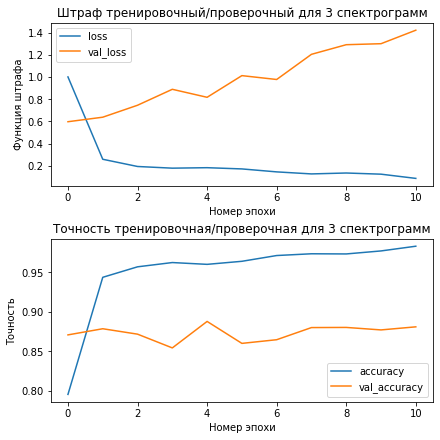

In [31]:
k = k_max
with open(f'./history_mdct_{k}_epoch.data', 'rb') as f:
    h_epoch = pickle.load(f)
with open(f'./history_mdct_{k}_history.data', 'rb') as f:
    h_history = pickle.load(f)
#metrics = histories[k].history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(h_epoch, h_history['loss'], h_history['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для {num_frame[k]} спектрограмм')

axes[1].plot(h_epoch, h_history['accuracy'], h_history['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для {num_frame[k]} спектрограмм')

In [32]:
print('Лучшее количество спектрограмм: ', num_frame[k_max])

Лучшее количество спектрограмм:  3


In [33]:
from tensorflow.keras.models import load_model
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = preprocess_dataset(train_files,num_frame[k_max])
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,num_frame[k_max])
test_ds = preprocess_dataset(test_files,num_frame[k_max])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_ = load_model(f"model_mdct_{k_max}.h5")

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

85/85 [==============================] - 1s 7ms/step


88.55555555555556

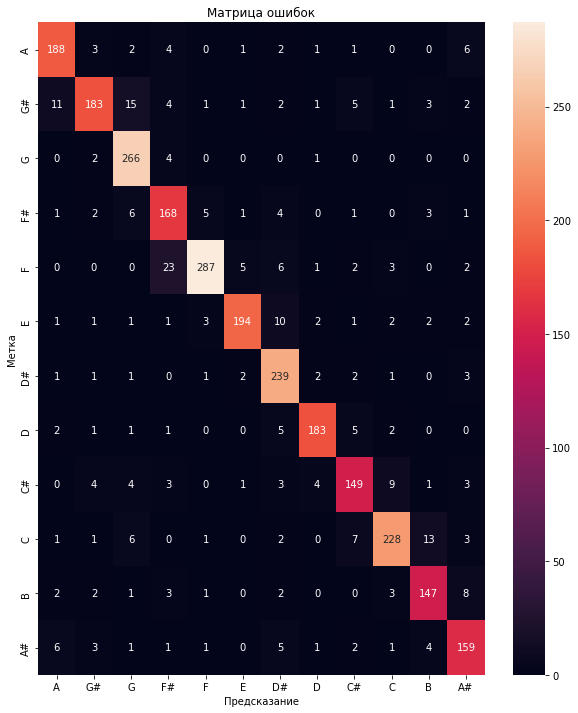

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


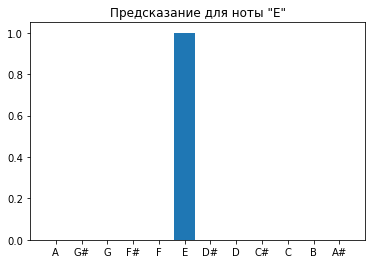

1


In [35]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)

sample_ds = preprocess_dataset([str(sample_file)],num_frame[k_max])
count = 0 
for spectrogram, label in sample_ds.batch(1):
    count+=1
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()
print(count)

In [36]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_mdct_new.h5")

C:\Users\belas\AppData\Local\Temp/ipykernel_9864/3168724974.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


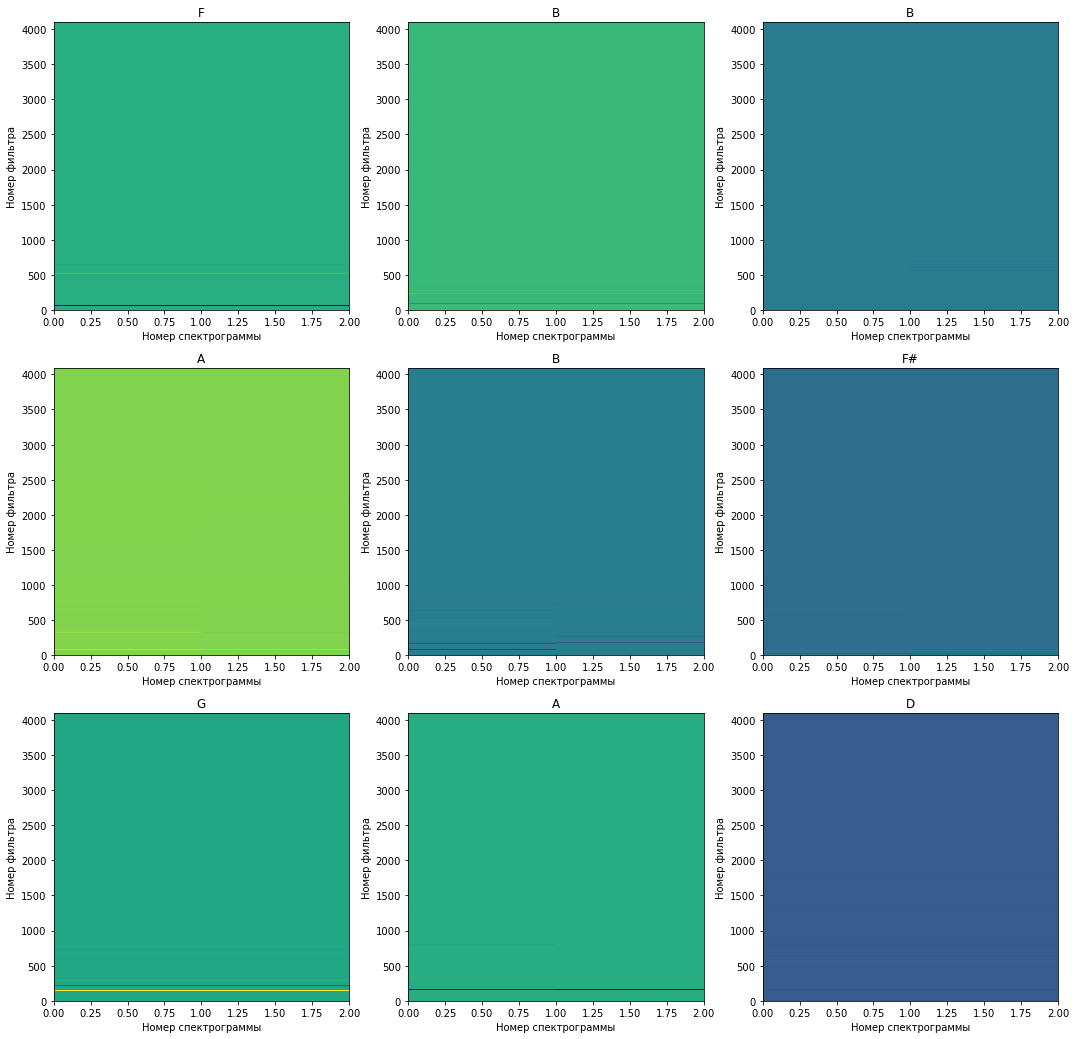

In [38]:


rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_xlabel('Номер спектрограммы')
    axes[r][c].set_ylabel('Номер фильтра')


plt.show()

Видно, что спектрограммы практически не несут никакой информации.

In [39]:
model_.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 3, 4096)]         0         
                                                                 
 flatten_5 (Flatten)         (None, 12288)             0         
                                                                 
 relu_1 (Dense)              (None, 512)               6291968   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 6,823,436
Trainable params: 6,823,436
Non-tra

Пробуем увеличить количество эпох для 3 спектрограмм.

In [42]:
EPOCHS = 50

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('input_shape',input_shape)

input_shape (3, 4096)


In [46]:
print('---------------------------------------------------------------------')
print('Количество спектрограмм: ',num_frame[k_max])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

mymodel = create_model(input_shape)

start_time = time.time()
myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)
                        #callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

---------------------------------------------------------------------
Количество спектрограмм:  3
2022-06-09 18:31:24
Epoch 1/50
296/296 [==============================] - 7s 22ms/step - loss: 0.9522 - accuracy: 0.8005 - val_loss: 0.6048 - val_accuracy: 0.8667
Epoch 2/50
296/296 [==============================] - 6s 22ms/step - loss: 0.2860 - accuracy: 0.9377 - val_loss: 0.7083 - val_accuracy: 0.8650
Epoch 3/50
296/296 [==============================] - 6s 22ms/step - loss: 0.2120 - accuracy: 0.9559 - val_loss: 0.8217 - val_accuracy: 0.8731
Epoch 4/50
296/296 [==============================] - 6s 22ms/step - loss: 0.2284 - accuracy: 0.9516 - val_loss: 0.8863 - val_accuracy: 0.8661
Epoch 5/50
296/296 [==============================] - 6s 22ms/step - loss: 0.1672 - accuracy: 0.9644 - val_loss: 0.9338 - val_accuracy: 0.8802
Epoch 6/50
296/296 [==============================] - 6s 22ms/step - loss: 0.1222 - accuracy: 0.9744 - val_loss: 1.0048 - val_accuracy: 0.8831
Epoch 7/50
296/296 [====

In [47]:
metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Количество спектрограмм: ',num_frame[k], ', accuracy тестовой выборки: ', test_acc, '%')

85/85 [==============================] - 0s 4ms/step
Количество спектрограмм:  3 , accuracy тестовой выборки:  87.77777777777777 %


[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для 3 спектрограмм на 50 эпохах')]

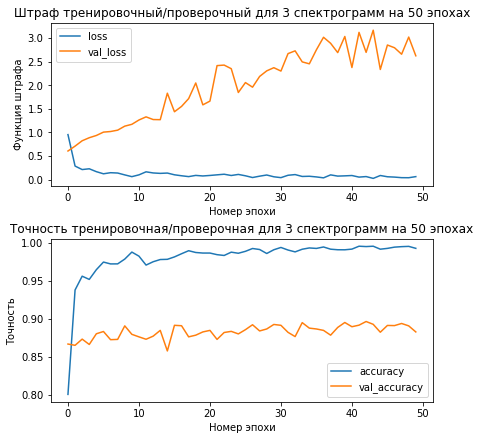

In [48]:
metrics = myhistory.history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для {num_frame[k_max]} спектрограмм на 50 эпохах')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для {num_frame[k_max]} спектрограмм на 50 эпохах')